# Import module

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

Or from the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

import matplotlib.pyplot as plt

## ImageAnalysis3 and basic modules

In [2]:
# Pu's ImageAnalysis3
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib inline

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast


12120


## Chromatin_analysis_tools etc

See **functions** in the repository for [AnalysisTool_Chromatin](../../README.md)

In [3]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

# Define folders

In [4]:
# main folder for postanalysis
postanalysis_folder = r'L:\Shiwei\postanalysis_2024\v0'
# input files for postanalysis
input_folder = os.path.join(postanalysis_folder, 'resources_from_preprocess')

# output file to be generated
output_main_folder = os.path.join(postanalysis_folder, 'method_overview')

output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

# make new folder if needed
make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\postanalysis_2024\v0\method_overview\analysis.
Use existing figure folder: L:\Shiwei\postanalysis_2024\v0\method_overview\figures.


# Plotting parameters

In [5]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# Other required plotting parameters
_dpi = 300
_font_size = 7
_page_width = 5.5

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=_dpi/2, dpi_save=_dpi, frameon=False, 
                              figsize=(_page_width/2, _page_width/2), fontsize=_font_size, facecolor='white', transparent=True)
sc.settings.figdir = output_figure_folder

# Load data relevant information

## load and format codebook

[merged codebook](../resources/merged_codebook.csv) as in the repository (merged for all DNA-MERFISH libraries)

In [7]:
# Load codebook 
codebook_fname = os.path.join(input_folder,'merged_codebook.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df by chr and chr_order
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)
codebook_df.head()

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3742742-3759944,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6245958-6258969,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740008-8759916,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016,1:9627926-9637875,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017,1:9799472-9811359,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
codebook_df[codebook_df['chr']=='5']

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
267,5:3745980-3759970,281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285,5:4045558-4060101,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1286,5:4984462-4996800,277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1287,5:5266903-5275975,278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268,5:6241707-6257332,282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,5:147716011-147736011,Flt1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1339,5:148515091-148526288,333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,5:148751996-148759872,339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1340,5:150135786-150145708,334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Format the chr loci name by 
# 1. changing loci name format
# 2. extract relevant information such as id, chr, chr_order, and library etc
from gene_to_loci import loci_pos_format
loci_name_list = list(map(loci_pos_format, codebook_df['name'].tolist()))
loci_name_arr = np.array(loci_name_list)

# convert to a new dataframe and set loci name as index
codebook_df = codebook_df[['name','id','chr','chr_order','library']]
codebook_df['loci_name'] = list(loci_name_arr[:,0])
codebook_df = codebook_df.set_index ('loci_name')

codebook_df.head()

,name,id,chr,chr_order,library
loci_name,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0.0,CTP11
chr1_6245958_6258969,1:6245958-6258969,2,1,1.0,CTP11
chr1_8740008_8759916,1:8740008-8759916,3,1,2.0,CTP11
chr1_9627926_9637875,1:9627926-9637875,1,1,3.0,CTP13
chr1_9799472_9811359,1:9799472-9811359,2,1,4.0,CTP13


# Load two MERFISH datasets and preprocess the data

In [10]:
import scanpy as sc

## load uncleared RNA MERFISH data for gene indexes 
**new_labeled_data** can be generated by juypter notebook from the relative path below:

[preprocess/1_rna_merfish/scripts/3_rna_merfish_celltype_rename](../../../preprocess/1_rna_merfish/scripts/3_rna_merfish_celltype_rename.ipynb)


In [11]:
target_adata_folder = r'L:\Shiwei\RNA_MERFISH_analysis\Merged_nonclear'
# load the processed adata that has UMAP and label information
merged_adata = sc.read(os.path.join(target_adata_folder,'new_labeled_data.h5ad'))

In [12]:
merged_adata

AnnData object with n_obs × n_vars = 62732 × 242
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'experiment', 'n_genes_by_counts', 'total_counts', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_subclass', 'subclass_prediction_label', 'leiden_subclass_sub', 'subclass_manual_label', 'subclass_manual_label_predict', 'subclass_label_new', 'class_label_new', 'neuron_identity'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'dendrogram_subclass_label_new', 'experiment_colors', 'leiden', 'leiden_colors', 'leiden_subclass_colors', 'leiden_subclass_sub_colors', 'neighbors', 'pca', 'scrublet', 'subclass_label_new_colors', 'subclass_manual_label_colors', 'subclass_prediction_label_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [13]:
merged_adata.X[:5,:5]

array([[-0.19366378, -0.21475439, -0.16190891, -0.24930467, -0.37091696],
       [ 7.528474  ,  6.03103   ,  7.920409  , -0.24920058, -0.3708265 ],
       [-0.18489227, 10.        , -0.15212041, -0.24233188, -0.3648586 ],
       [ 5.0205736 , -0.23393908, -0.17388886,  3.2742507 , -0.37833166],
       [-0.18620144,  9.402692  , -0.15358138, -0.2433726 , -0.36576283]],
      dtype=float32)

C:\Users\shiwei\Anaconda3\envs\shiwei_chromatin\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


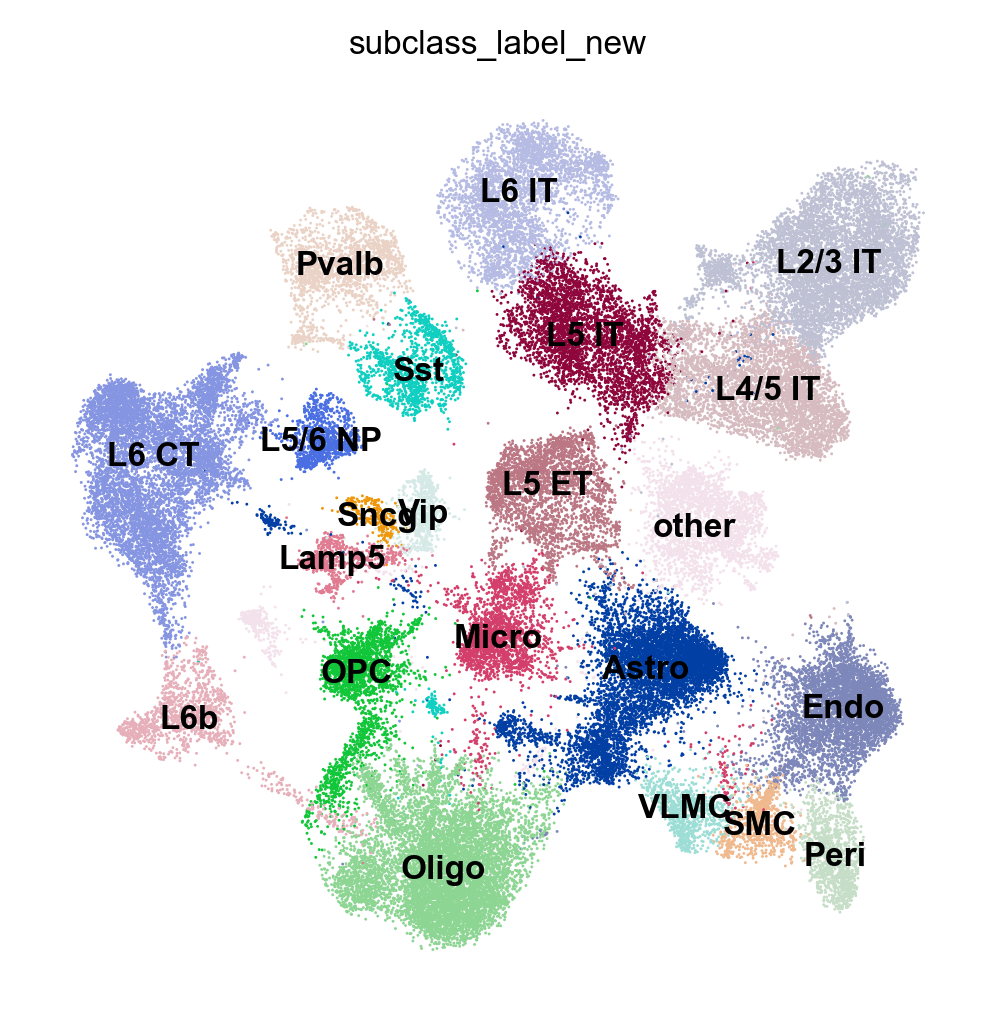

In [14]:
# Plot UMAP to check; modify the plotting appearance later
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, 
                              figsize=(4, 4), fontsize=8, facecolor='white',)

sc.pl.umap(merged_adata, color='subclass_label_new', legend_loc='on data')

## load Meng's dataset as reference
https://doi.org/10.1038/s41586-021-03705-x


In [15]:
from sklearn import preprocessing
#adata_mer = adata_mer
MOp_MERFISH_meng_preprocessed_for_integration_file =r'L:\Shiwei\RNA_MERFISH_analysis\Meng_data\counts.h5ad'
merfish_ref = sc.read_h5ad(MOp_MERFISH_meng_preprocessed_for_integration_file)

In [16]:
merfish_ref.X[:5,:5]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 25.56704   ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.49162862,  0.        ,  0.98325723,  0.49162862]],
      dtype=float32)

In [17]:
merfish_label = pd.read_csv(r'L:\Shiwei\RNA_MERFISH_analysis\Meng_data\cell_labels.csv', index_col=0)

In [18]:
merData = pd.DataFrame(merfish_ref.X, index = merfish_ref.obs.index, columns = merfish_ref.var.index)
labels = merfish_label.loc[merfish_label['label']!='-1']
# merge dataframes
merCluster=merData.merge(labels, how='inner', left_index=True, right_index=True)

In [19]:
from sklearn import preprocessing
# Scale variable measurements for model training
merGroupedDataZ = pd.DataFrame(preprocessing.scale(merCluster.iloc[:,:-5]),index = merCluster.iloc[:,:-5].index, columns = merCluster.iloc[:,:-5].columns)

merGroupedDataZ['subclass'] = merCluster.iloc[:,-2]

C:\Users\shiwei\Anaconda3\envs\shiwei_chromatin\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
C:\Users\shiwei\Anaconda3\envs\shiwei_chromatin\lib\site-packages\sklearn\preprocessing\_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [20]:
merGroupedDataZ

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Tac2,Lamp5,Cnr1,Pvalb,Sst,Rab3b,Slc17a7,Penk,Gad1,subclass
index,,,,,,,,,,,,,,,,,,,,,
10000143038275111136124942858811168393,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.348175,-0.274825,...,-0.384528,-0.483580,-0.246400,-0.346832,-0.126652,-0.780719,-0.971601,-0.381083,-0.245849,Astro
100001798412490480358118871918100400402,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.481826,-0.447294,-0.255495,-0.383033,-0.095295,-0.624110,-0.970920,-0.364425,-0.245849,Endo
100006878605830627922364612565348097824,-0.14432,-0.270846,-0.161999,-0.222231,5.728458,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.780022,-0.507845,-0.195420,-0.401427,-0.136333,-0.688766,-0.997852,-0.376900,-0.245849,SMC
100007228202835962319771548915451072492,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.836989,-0.486484,-0.125615,-0.341760,-0.149984,-0.729377,-0.891460,-0.410295,-0.111492,Endo
100009332472089331948140672873134747603,-0.14432,1.116969,-0.161999,3.536333,-0.110647,-0.215885,-0.305883,-0.257521,-0.264185,-0.274825,...,0.343120,1.874451,-0.255495,-0.230569,0.101786,0.690105,0.742187,0.076623,-0.245849,L2/3 IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,-0.14432,-0.270846,-0.161999,1.909306,-0.225128,-0.215885,-0.305883,-0.257521,-0.374588,1.675924,...,1.984689,-0.507845,0.054276,1.175393,-0.087147,3.619679,-0.816871,-0.232083,2.201252,Pvalb
99989592830367590092304100078674096866,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,0.092527,3.276286,-0.274825,...,-0.656887,-0.100963,-0.229291,-0.480851,-0.153879,-0.620974,-0.281065,-0.247383,-0.214862,L5 ET
99991756591196613545069880666241120777,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.492898,-0.418007,0.475379,-0.231175,-0.115953,-0.381186,-0.169621,-0.376207,-0.244550,L4/5 IT


# Train classfier with Meng's dataset

## train classifer de novo

In [21]:
adata_ref = merGroupedDataZ

# Train the classifer using the shared varibales
genes_from_ref = set(merData.columns)
genes = list(genes_from_ref.intersection(set(merged_adata.var.index)))

In [22]:
%%time
from sklearn.neural_network import MLPClassifier

# Train a classifier
gene_ids = [merData.columns.get_loc(g) for g in genes]

print('Train cell type classifier.')

X = np.array(adata_ref.iloc[:,:-1])[:, gene_ids]
Y = np.array(adata_ref['subclass'])
nnc = MLPClassifier(max_iter = 500)
nnc.fit(X, Y)

Train cell type classifier.
CPU times: total: 1h 52min 40s
Wall time: 5min 39s


MLPClassifier(max_iter=500)

## save the trained classifer

In [23]:
import pickle
nnc_pkl_fname = os.path.join(output_analysis_folder, 'trained_MLP_classifier.pkl')
pickle.dump(nnc, open(nnc_pkl_fname, 'wb'))

## load pre-trained classifer (may not work this way)

# Make prediction

## define functions

In [24]:
# Sorting code from Xingjie adapted from Meng
from random import choice

def permuteOrder(df,axis,switch = 0):
    penaltyMat = np.zeros((df.shape[0],df.shape[1]))
    for i in range(penaltyMat.shape[0]):
        for j in range(penaltyMat.shape[1]):
            penaltyMat[i,j] = np.abs(i-(df.shape[0])/(df.shape[1])*j)**0.5
    if axis == 0:
        sort = df.index.values.copy()
    elif axis == 1:
        sort = df.columns.values.copy()
    dfCopy = df.values.copy()
#     print(dfCopy)
    for i in range(df.shape[int(axis)]):
        penalty = np.full((df.shape[int(axis)]),np.inf)
        for j in range(len(penalty)):
            tempMat = dfCopy.copy()
            if axis == 0:
                tempMat[[i, j],:] = tempMat[[j, i],:]
            elif axis == 1:
                tempMat[:,[i, j]] = tempMat[:,[j, i]]
            penalty[j] = sum(sum(tempMat*penaltyMat))
        idx = np.argmin(penalty)
        if not idx == i:                
            switch += 1
        if axis == 0:
            dfCopy[[i, idx], :] = dfCopy[[idx, i], :];
        elif axis == 1:
            dfCopy[:,[i, idx]] = dfCopy[:,[idx, i]];
        else:
            print('bad axis {}'.format(axis))
        sort[[i, idx]] = sort[[idx, i]]
    return switch,sort

def runPermutation(df, axis = 'Both', maxIter = 100,maxTrys = 9):  # initial maxTrys = 5
    iterations = 0
    trys = 0
    sortedDF = df.copy(deep=True)
    while iterations < maxIter:
        if axis == 'Both':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            switch,columnSort = permuteOrder(sortedDF,1,switch)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
        if axis == 'Rows':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,:].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                 iterations = maxIter
        if axis == 'Columns':
            switch,columnSort = permuteOrder(sortedDF,1)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[:,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
    return sortedDF, sortedDF.index, sortedDF.columns

In [25]:
def train_nn_gene_exp_classifier(adata, label_column, genes):
    '''Train a nueral net classifier using the gene expressions.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    Y = np.array(adata.obs[label_column])
    
    nnc = MLPClassifier(max_iter = 500)
    nnc.fit(X, Y)
    return nnc

def predict_classes(classifier, adata, prediction_column, genes):
    '''Predict the classes of cells using a trained classifier.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    adata.obs[prediction_column] = classifier.predict(X)
    
def plot_cluster_correspondance(adata_ref, adata_query, ref_cluster_column, query_cluster_column,
                                prediction_column='predicted_classes', genes=None):
    '''Plot the correspondance between clusters from two data sets.'''
    # Make a copy of the query data set

    adata_query = adata_query.copy()
    
    # Use the shared genes for predictions if the gene set is not specified
    if genes is None:
        genes = list(set(adata_ref.var.index).intersection(set(adata_query.var.index)))
        
    # Train a classifier
    print(f'Train a classifier using {len(genes)} genes and {adata_ref.shape[0]} cells.')
    nnc = train_nn_gene_exp_classifier(adata_ref, ref_cluster_column, genes)
    

        
    
    # Make predictions
    print('Predict cell types.')
    predict_classes(nnc, adata_query, prediction_column, genes)
    
    # Count predictions
    prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
    prediction_counts['count'] = 1
    
    predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)
    predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
    #fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
    fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
    # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel(ref_cluster_column) 
    plt.ylabel(query_cluster_column)
    plt.show()
    
    return fractions_sorted
    

##  predict the uncleared MOp

In [26]:
adata_query = merged_adata

In [27]:
prediction_column = 'subclass_manual_label_predict'

ref_cluster_column = 'subclass'
ref_cluster_column = 'subclass_manual_label_predict'
# determine which class to query
check_query_cluster_column = 'subclass_manual_label'

print(f'Predict cell types: {check_query_cluster_column}')
predict_classes(nnc, merged_adata, prediction_column, genes)
 
    
## Count predictions
prediction_counts = merged_adata.obs[[check_query_cluster_column, prediction_column]]
prediction_counts['count'] = 1

predictionMatrix = pd.pivot_table(prediction_counts, index=[check_query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = clsf.runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')

Predict cell types: subclass_manual_label


C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_12120\1287916853.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


In [28]:
fractions_sorted.head()

subclass_manual_label_predict,Micro,Sst,L5/6 NP,L5 ET,L6b,other,PVM,OPC,L6 CT,L6 IT,...,Oligo,L2/3 IT,Pvalb,SMC,L6 IT Car3,L4/5 IT,L5 IT,Vip,VLMC,Sncg
subclass_manual_label,,,,,,,,,,,,,,,,,,,,,
Micro,0.825000,0.001786,0.003125,0.000446,0.002232,0.000000,0.025000,0.002679,0.008929,0.011607,...,0.025446,0.022768,0.007143,0.008036,0.000893,0.017857,0.020089,0.00000,0.001339,0.000000
Sst,0.003826,0.952563,0.000000,0.000000,0.000000,0.000000,0.000765,0.005356,0.000000,0.000000,...,0.009181,0.000765,0.017598,0.000000,0.000000,0.001530,0.000765,0.00153,0.000000,0.000765
L5/6 NP,0.000000,0.003027,0.963673,0.001009,0.000000,0.001009,0.000000,0.002018,0.016145,0.000000,...,0.001009,0.000000,0.002018,0.000000,0.000000,0.000000,0.008073,0.00000,0.000000,0.000000
L5 ET,0.016356,0.002282,0.001141,0.913275,0.000000,0.000000,0.000761,0.000761,0.003804,0.002282,...,0.014454,0.003043,0.003043,0.000000,0.000000,0.000761,0.001141,0.00000,0.000000,0.000000
L6b,0.000784,0.000000,0.003922,0.000000,0.919216,0.000000,0.000000,0.000784,0.002353,0.003137,...,0.047843,0.001569,0.002353,0.000000,0.000784,0.000000,0.000784,0.00000,0.001569,0.000000


## save/load the prediction result

In [29]:
celltype_prediction_fname = os.path.join(output_analysis_folder, 'MOp_celltype_prediction.csv')

overwrite_prediction=False
if not overwrite_prediction and os.path.exists(celltype_prediction_fname):
    print ('Load saved prediction result.')
    fractions_sorted = pd.read_csv(celltype_prediction_fname, index_col=0)
else:
    print ('Save prediction result.')
    fractions_sorted.to_csv(celltype_prediction_fname)
    
fractions_sorted.head()

Load saved prediction result.


,Astro,Endo,L2/3 IT,L4/5 IT,L5 ET,Lamp5,PVM,L5 IT,Vip,L6b,...,Oligo,Sst,Pvalb,SMC,L6 IT Car3,Sncg,L6 IT,VLMC,L5/6 NP,L6 CT
subclass_manual_label,,,,,,,,,,,,,,,,,,,,,
Astro,0.860497,0.008342,0.010042,0.014985,0.001545,0.004171,0.000154,0.015449,0.003399,0.005407,...,0.004635,0.008651,0.002935,0.000927,0.000618,0.000309,0.010969,0.010814,0.003090,0.003090
Endo,0.005415,0.849469,0.002382,0.001733,0.001516,0.001083,0.047217,0.001733,0.000433,0.000000,...,0.003249,0.001083,0.000433,0.033572,0.000000,0.000000,0.000866,0.011046,0.000433,0.000000
L2/3 IT,0.000829,0.001491,0.917316,0.065120,0.000829,0.001326,0.000000,0.004143,0.001160,0.000166,...,0.000166,0.000331,0.000000,0.000000,0.000000,0.000166,0.003977,0.000000,0.000994,0.000166
L4/5 IT,0.000000,0.000711,0.056201,0.933839,0.000237,0.000474,0.000000,0.003794,0.000000,0.000000,...,0.000237,0.000711,0.000949,0.000000,0.000000,0.000000,0.002134,0.000000,0.000000,0.000000
L5 ET,0.033473,0.001141,0.002663,0.000761,0.916698,0.001902,0.000000,0.001521,0.000380,0.000000,...,0.019399,0.001521,0.001902,0.000000,0.000000,0.000000,0.001141,0.000380,0.001902,0.000761


## plot the correspondance matrix

In [30]:
# re-order the celltypes
sorted_predicted_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           'other',
                          ]

fractions_sorted_by_label = fractions_sorted[sorted_predicted_labels]
fractions_sorted_new, rows, columns = runPermutation(fractions_sorted_by_label,'Rows',maxIter = 100,maxTrys = 15)
#fractions_sorted, rows, columns = runPermutation(fractions_sorted,'Rows',maxIter = 100,maxTrys = 15)

In [31]:
fractions_sorted_new

,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L5/6 NP,L6 CT,L6b,Sst,Pvalb,...,Vip,Astro,Oligo,OPC,Micro,Endo,VLMC,SMC,Peri,other
subclass_manual_label,,,,,,,,,,,,,,,,,,,,,
L2/3 IT,0.917316,0.065120,0.004143,0.003977,0.000829,0.000994,0.000166,0.000166,0.000331,0.000000,...,0.001160,0.000829,0.000166,0.000331,0.001326,0.001491,0.000000,0.000000,0.000000,0.000166
L4/5 IT,0.056201,0.933839,0.003794,0.002134,0.000237,0.000000,0.000000,0.000000,0.000711,0.000949,...,0.000000,0.000000,0.000237,0.000237,0.000474,0.000711,0.000000,0.000000,0.000000,0.000000
L5 IT,0.011126,0.202119,0.728212,0.019338,0.013245,0.004503,0.000530,0.000000,0.001589,0.001589,...,0.000795,0.002119,0.001325,0.001325,0.001589,0.009536,0.000000,0.000530,0.000265,0.000000
L6 IT,0.004877,0.005486,0.213045,0.757696,0.000305,0.000610,0.000000,0.000000,0.003048,0.000610,...,0.000000,0.000305,0.001829,0.000610,0.000000,0.005791,0.000000,0.000000,0.000000,0.000610
L5 ET,0.002663,0.000761,0.001521,0.001141,0.916698,0.001902,0.000761,0.000000,0.001521,0.001902,...,0.000380,0.033473,0.019399,0.000761,0.013693,0.001141,0.000380,0.000000,0.000000,0.000000
L5/6 NP,0.001009,0.001009,0.009082,0.000000,0.001009,0.967709,0.006054,0.000000,0.002018,0.000000,...,0.000000,0.000000,0.001009,0.006054,0.002018,0.003027,0.000000,0.000000,0.000000,0.000000
L6 CT,0.000144,0.000000,0.002304,0.006048,0.002880,0.003024,0.957949,0.014833,0.001872,0.003024,...,0.000144,0.000288,0.001584,0.001152,0.000720,0.001584,0.000144,0.000288,0.000288,0.000576
L6b,0.000784,0.000000,0.000784,0.000784,0.000000,0.003922,0.000000,0.898824,0.000784,0.001569,...,0.000000,0.000000,0.074510,0.000784,0.001569,0.010196,0.001569,0.000000,0.000784,0.000000
Sst,0.000765,0.001530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.954858,0.018363,...,0.000765,0.001530,0.006121,0.006121,0.003826,0.000000,0.000765,0.000000,0.000000,0.000000


In [32]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

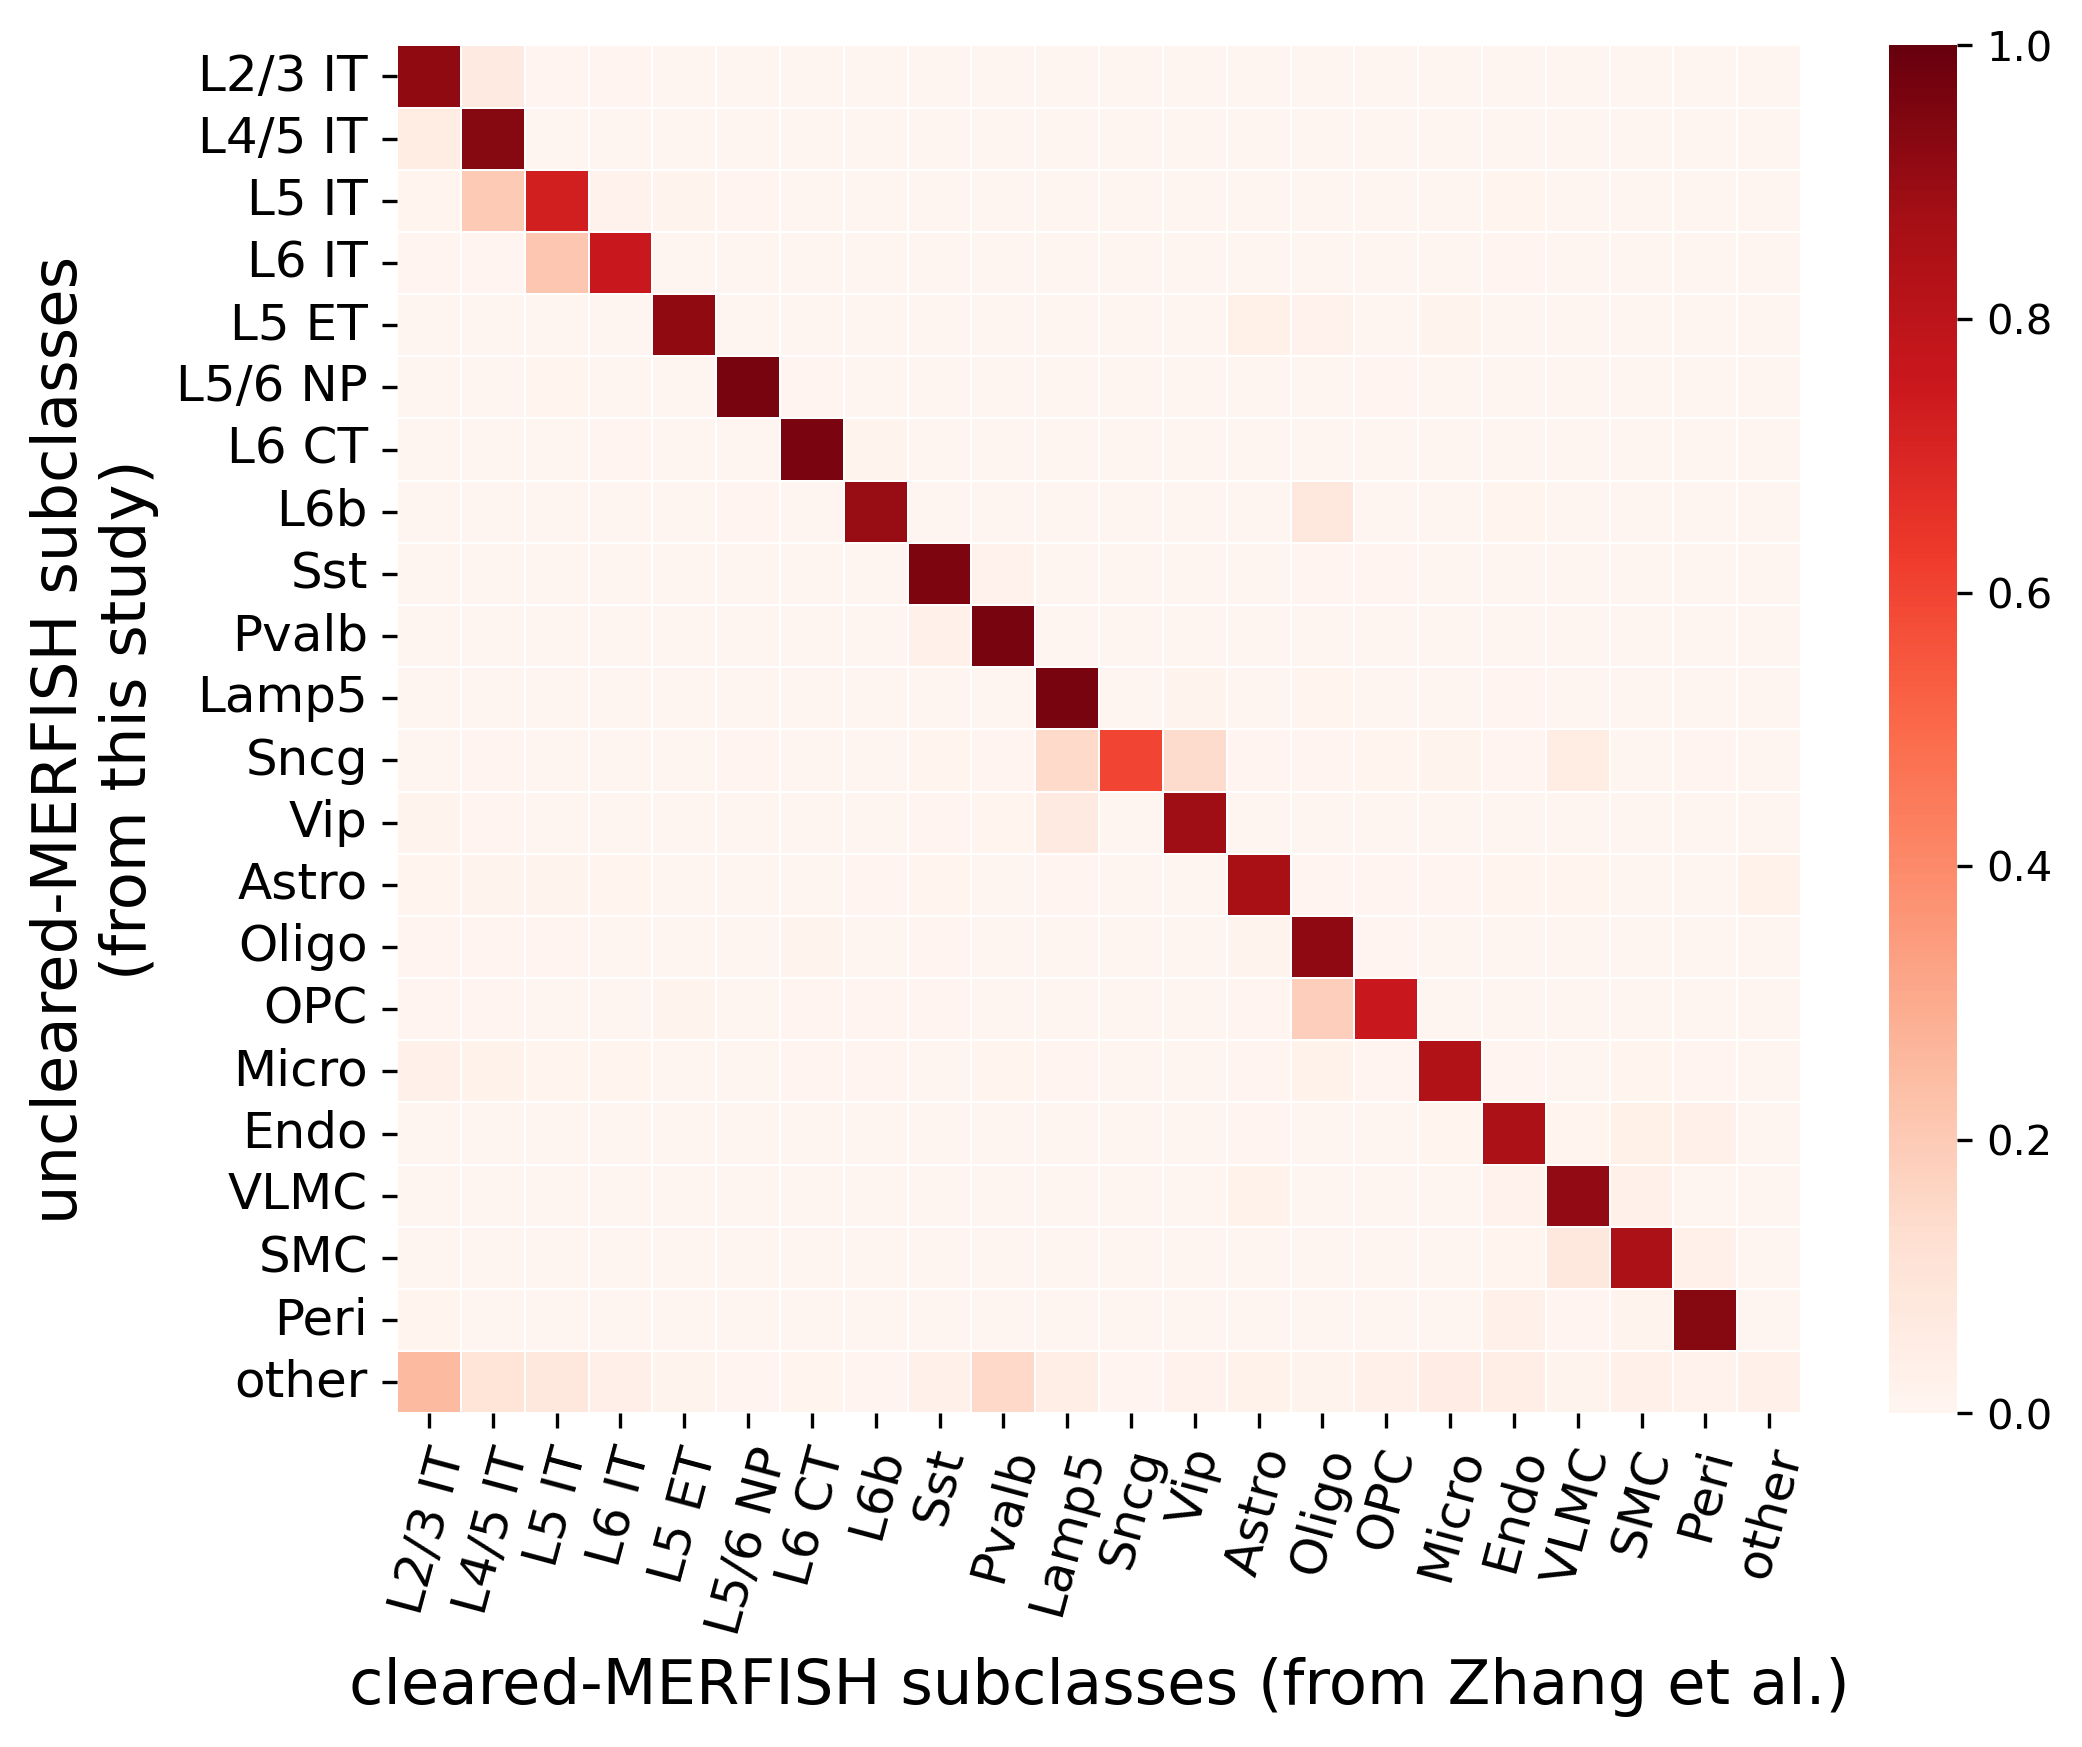

In [33]:
# Plot to check the result
fig= plt.figure(figsize = (7.5,6), dpi=150)
plt.style.use('default')


#sns.set(font_scale=0.2)

ax = sns.heatmap(fractions_sorted_new, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": 1})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)   
plt.xticks(rotation = 75)
plt.yticks(rotation = 'horizontal')
#plt.xlabel(ref_cluster_column, size=12) 
#plt.ylabel(check_query_cluster_column, size=12)

plt.xlabel('cleared-MERFISH subclasses (from Zhang et al.)', size=15) 
plt.ylabel('uncleared-MERFISH subclasses \n (from this study)', size=15)

#plt.savefig(os.path.join(output_figure_folder, 'MOp_celltype_prediction.pdf'), 
            #transparent=True, dpi=300, bbox_inches='tight')
plt.show()